# Auditing a Causal Language Model (LM) using the Population Attack

[Citation](https://github.com/privacytrustlab/ml_privacy_meter/blob/master/advanced/hf_causal_language_models.ipynb)

## Imports

In [35]:
import sys
import numpy as np
import torch
from typing import List, Tuple

In [36]:
!{sys.executable} -m pip install datasets
!{sys.executable} -m pip install transformers
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from IPython.display import clear_output
clear_output()

In [37]:
!pip install privacy-meter
!pip install opacus
from IPython.display import clear_output
clear_output()

In [38]:
# !{sys.executable} -m pip install -e ../.
from privacy_meter.audit import Audit
from privacy_meter.dataset import Dataset
from privacy_meter.hypothesis_test import threshold_func
from privacy_meter.information_source import InformationSource
from privacy_meter.information_source_signal import Signal
from privacy_meter.model import Model
from privacy_meter.metric import PopulationMetric
from privacy_meter.constants import InferenceGame
from privacy_meter.audit_report import ROCCurveReport, SignalHistogramReport

## Hyperparameters

In [39]:
# a toy example for the population metric
num_train_seqs = 25
num_test_seqs = 25
num_population_seqs = 100
fpr_tolerance_list = [0.0, 0.1, 0.5, 0.9, 1.0]

## Load dataset and model using HuggingFace

### Load and split dataset

In [40]:
# download dataset from huggingface
hf_dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

# remove empty rows
hf_dataset = hf_dataset.filter(lambda elem: len(elem["text"]) > 0)

### Load and finetune model

In [41]:
# load pretrained and tokenizer
model_id = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model_obj = AutoModelForCausalLM.from_pretrained(model_id)

We tokenize and group the dataset before finetuning the model:

In [42]:
def tokenize_fn(examples):
    return tokenizer(examples["text"])

tokenized_hf_dataset = hf_dataset.map(
    tokenize_fn, batched=True, num_proc=2, remove_columns=["text"]
)

In [43]:
block_size = 128
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])

    total_length = (total_length // block_size) * block_size

    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }

    result["labels"] = result["input_ids"].copy()
    return result

lm_hf_dataset = tokenized_hf_dataset.map(
    group_texts, batched=True, batch_size=64, num_proc=2
)

In [44]:
finetune_args = TrainingArguments(num_train_epochs=5, output_dir="privacy_meter_logs/")

In [45]:
hf_trainer = Trainer(
    model=model_obj,
    args=finetune_args,
    train_dataset=lm_hf_dataset["train"].select(range(num_train_seqs)),
    eval_dataset=lm_hf_dataset["validation"]
)

hf_trainer.train()

Step,Training Loss


TrainOutput(global_step=20, training_loss=3.822214889526367, metrics={'train_runtime': 7.5059, 'train_samples_per_second': 16.653, 'train_steps_per_second': 2.665, 'total_flos': 4082761728000.0, 'train_loss': 3.822214889526367, 'epoch': 5.0})

## Extend Privacy Meter to work with HuggingFace Causal LMs

### Extend the Model class

In [46]:
class HfCausalLMModel(Model):
    """Inherits of the Model class, an interface to query a model without any assumption on how it is implemented.
    This particular class is to be used with HuggingFace Causal LM models.
    """

    def __init__(self, model_obj, loss_fn, stride=64):
        """Constructor
        Args:
            model_obj: model object
            loss_fn: loss function
            stride: window size that will be used by the fixed length
            causal model for processing an input sequence
        """

        # Initializes the parent model
        super().__init__(model_obj, loss_fn)

        self.stride = stride

    def get_outputs(self, batch_samples):
        """Function to get the model output from a given input.
        Args:
            batch_samples: Model input
        Returns:
            Model output
        """
        pass

    def get_loss(self, batch_samples, batch_labels):
        """Function to get the model loss on a given input and an expected output.
        Args:
            batch_samples: Model input
            batch_labels: Model expected output
        Returns:
            The loss value, as defined by the loss_fn attribute.
        """
        pass

    def get_logits(self, batch_samples):
        return super().get_logits(batch_samples)
    def get_grad(self, batch_samples, batch_labels):
        """Function to get the gradient of the model loss with respect to the model parameters, on a given input and an
        expected output.
        Args:
            batch_samples: Model input
            batch_labels: Model expected output
        Returns:
            A list of gradients of the model loss (one item per layer) with respect to the model parameters.
        """
        pass

    def get_intermediate_outputs(self, layers, batch_samples, forward_pass=True):
        """Function to get the intermediate output of layers (a.k.a. features), on a given input.
        Args:
            layers: List of integers and/or strings, indicating which layers values should be returned
            batch_samples: Model input
            forward_pass: Boolean indicating if a new forward pass should be executed. If True, then a forward pass is
                executed on batch_samples. Else, the result is the one of the last forward pass.
        Returns:
            A list of intermediate outputs of layers.
        """
        pass

    def get_perplexity(self, batch_samples):
        """Function to get the perplexity of the model loss, on a given input sequence.
        Args:
            batch_samples: Model input
        Returns:
            A list of perplexity values.
        """
        max_length = self.model_obj.config.n_positions

        ppl_values = []
        for sample in batch_samples:
            sample_length = len(sample)

            sample = np.expand_dims(sample, axis=0) # the model takes in a batch of sequences
            sample = torch.tensor(sample, dtype=torch.long)

            nlls = []
            for i in range(0, sample_length, self.stride):
                begin_loc = max(i + self.stride - max_length, 0)
                end_loc = min(i + self.stride, sample_length)

                trg_len = end_loc - i  # may be different from stride on last loop

                input_ids = sample[:, begin_loc:end_loc]
                target_ids = input_ids.clone()
                target_ids[:, :-trg_len] = -100

                with torch.no_grad():
                    outputs = self.model_obj(input_ids, labels=target_ids)
                    neg_log_likelihood = outputs[0] * trg_len

                nlls.append(neg_log_likelihood)
            ppl = torch.exp(torch.stack(nlls).sum() / end_loc)

            ppl_values.append(ppl)

        return ppl_values

### Create a new Signal for computing perplexity

In [47]:
class ModelPerplexity(Signal):
    """
    Inherits of the Signal class, used to represent any type of signal that can be obtained from a Model and/or a Dataset.
    This particular class is used to get the perplexity of a model.
    """

    def __call__(self,
                 models: List[Model],
                 datasets: List[Dataset],
                 model_to_split_mapping: List[Tuple[int, str, str, str]],
                 extra: dict
                 ):
        """Built-in call method.
        Args:
            models: List of models that can be queried.
            datasets: List of datasets that can be queried.
            model_to_split_mapping: List of tuples, indicating how each model should query the dataset.
                More specifically, for model #i:
                model_to_split_mapping[i][0] contains the index of the dataset in the list,
                model_to_split_mapping[i][1] contains the name of the split,
                model_to_split_mapping[i][2] contains the name of the input feature,
                model_to_split_mapping[i][3] contains the name of the output feature.
                This can also be provided once and for all at the instantiation of InformationSource, through the
                default_model_to_split_mapping argument.
            extra: Dictionary containing any additional parameter that should be passed to the signal object.
        Returns:
            The signal value.
        """

        results = []
        # Compute the signal for each model
        for k, model in enumerate(models):
            # Extract the features to be used
            dataset_index, split_name, input_feature, output_feature = model_to_split_mapping[k]
            x = datasets[dataset_index].get_feature(split_name, input_feature)
            # Compute the signal
            results.append(model.get_perplexity(x))
        return results

### Audit LM using PopulationMetric

We first create the target and reference datasets using the `Dataset` class. Since we already processed the dataset before for finetuning, we do not need to pass a preprocessing function while creating the `Dataset` objects:

In [48]:
# split data into 'train', 'test', and 'population'
train_split = lm_hf_dataset["train"].select(range(num_train_seqs))
test_split =  lm_hf_dataset["test"].select(range(num_test_seqs))
population_split = lm_hf_dataset["train"].select(
    range(num_train_seqs, (num_train_seqs + num_population_seqs))
)

In [49]:
# set format of datasets to be compatible with Privacy Meter
train_split.set_format("numpy")
test_split.set_format("numpy")
population_split.set_format("numpy")

In [50]:
train_ds = {'input': train_split['input_ids']}
test_ds = {'input': test_split['input_ids']}
population_ds = {'input': population_split['input_ids']}

In [51]:
target_dataset = Dataset(
    data_dict={'train': train_ds, 'test': test_ds},
    default_input='input',
    default_output=None
)

In [52]:
reference_dataset = Dataset(
    data_dict={'train': population_ds},
    default_input='input',
    default_output=None
)

Then, we wrap the model we finetuned into our custom `HfCausalLMModel` class:

In [53]:
stride = 512
model_obj.to('cpu')
target_model = HfCausalLMModel(
    model_obj=model_obj,
    loss_fn=None,
    stride=stride
)

Next, we create the target and reference `InformationSource` objects for the audit:

In [54]:
target_info_source = InformationSource(
    models=[target_model],
    datasets=[target_dataset]
)

reference_info_source = InformationSource(
    models=[target_model],
    datasets=[reference_dataset]
)

And now we create a `PopulationMetric` object that uses perplexity as the signal:

In [55]:
population_metric_obj = PopulationMetric(
    target_info_source=target_info_source,
    reference_info_source=reference_info_source,
    signals=[ModelPerplexity()],
    hypothesis_test_func=threshold_func,
)

Finally, we create the `Audit` object and run the audit on our finetuned model:

In [56]:
audit_obj = Audit(
    metrics=population_metric_obj,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    fpr_tolerances=fpr_tolerance_list,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL
)
audit_obj.prepare()

audit_results = audit_obj.run()
for result in audit_results:
    print(result)

Results are stored in: ['/content/log_2024-08-01_07-27-59-000']


In [57]:
# This instruction won't be needed once the tool is on pip
from privacy_meter import audit_report
audit_report.REPORT_FILES_DIR = '../privacy_meter/report_files'

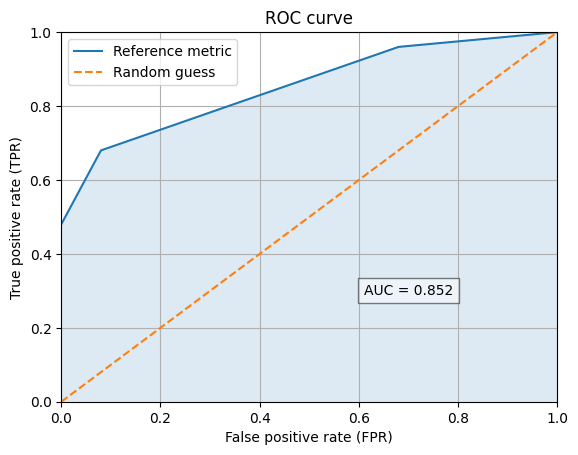

AUC = 0.852


<Figure size 640x480 with 0 Axes>

In [58]:
ROCCurveReport.generate_report(
    metric_result=audit_results[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

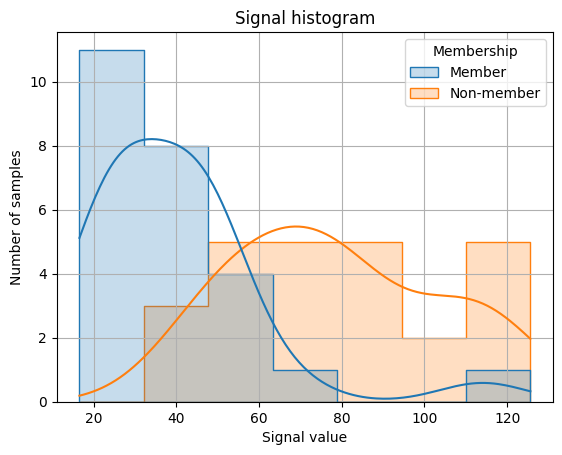

<Figure size 640x480 with 0 Axes>

In [59]:
SignalHistogramReport.generate_report(
    metric_result=audit_results[0][0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)